# Get Score from loadmonitor


## Notebook Preps


In [4]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

In [3]:
# change current directory to the project directory
import os
os.chdir('../../../')

In [3]:
!pip install -r ai/requirements.txt --user
!pip install python-dotenv

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     -------------------------- ------------- 41.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/99.4 kB ? eta -:--:--
     ---------------------------------------- 99.4/99.4 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting req

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\dotenv.exe' -> 'C:\\Python312\\Scripts\\dotenv.exe.deleteme'



First let's set environment variables. (in .env file in ai folder) (Note: also run the proxy script) Example would be

```env
CLUSTER_NAME=dev
DB_USER=asdf
DB_PASS=asdf
DB_ADDR=127.0.0.1
DB_PORT=5432
DB_NAME=lynus
DB_MODE=disable
S3_ENDPOINT=sos-at-vie-1.exo.io
S3_ACCESS_KEY=asdf
S3_SECRET_KEY=asdf
S3_SECURE=1
EMPA_ADDR=http://127.0.0.1:9000/
WEATHER_API_KEY=asdf
```


In [5]:
from dotenv import load_dotenv

load_dotenv("./ai/.env", override=True)

True

### Fetch all Models


In [6]:
import psycopg
import pandas as pd

# Get DB connection and all EMS models

try:
    # Establish a connection to the PostgreSQL database
    connection = psycopg.connect(
        dbname=os.environ["DB_NAME"],
        user=os.environ["DB_USER"],
        password=os.environ["DB_PASS"],
        host=os.environ["DB_ADDR"],
        port=os.environ["DB_PORT"]
    )

    # Create a cursor object to interact with the database
    cursor = connection.cursor()

    cursor.execute("SELECT models.id as model_id, models.r->'data'->>'type' as model_type, project.name as project_name, models.r->>'project_id' as project_id \
FROM models \
JOIN project ON models.r->>'project_id'= project.id::text \
WHERE models.r -> 'data' ->> 'type' LIKE '%LoadMonitor%' \
")
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Get column names


except psycopg.Error as e:
    print(f"Unable to connect to the database. Error: {e}")

finally:
    # Close the cursor and connection, regardless of whether the try block succeeds or raises an exception
    if connection:
        cursor.close()
        connection.close()
        print("Connection closed.")

# Convert the result to a Pandas DataFrame
model_df = pd.DataFrame(result, columns=columns)
model_df

Connection closed.


,model_id,model_type,project_name,project_id
0,6d6b9d77-e7ef-47e3-9b6f-8b29559d7dad,LoadMonitor,Demo Site #1,9cd72c35-5f60-49af-9bb5-b551ac54c00a
1,8b1a11ce-7a77-4081-a55f-b1f72a30a1d3,LoadMonitor,clone: Anker 1Meidlinger Haupt,42cf3b23-700d-4275-a072-1301ce2666ee
2,9498cd84-ad10-4016-b218-7d47c1dae811,LoadMonitor,Demo Site #2,c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc
3,12f5dffd-0fc5-40fc-885a-33c060fb6a15,LoadMonitor,Demo Site #2,c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc


In [7]:
from ai.interface.model_holder import ModelHolder
from ai.model_holder.load_monitor_model_holder import LoadMonitorModelHolder

index = 3
train_duration_weeks = 5

model_id = str(model_df.iloc[index]["model_id"])
model_holder_type = LoadMonitorModelHolder
model_holder = ModelHolder.load_model_holder_from_s3(
    model_id, model_holder_type, model_load=False, status_load=False)
data_holder = model_holder.get_dh()

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from ai.utils.http_utils import append_data_to_dataframe_http, fetch_data_from_http

start = 1715724000
end = 1715810399
df = data_holder.get_data(start=start, end=end)
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt
ts,
2024-05-15 00:00:00+02:00,4.16
2024-05-15 00:01:00+02:00,4.16
2024-05-15 00:02:00+02:00,4.16
2024-05-15 00:03:00+02:00,4.16
2024-05-15 00:04:00+02:00,4.16
...,...
2024-05-15 23:55:00+02:00,None
2024-05-15 23:56:00+02:00,None
2024-05-15 23:57:00+02:00,None


In [10]:
v = data_holder.get_prediction_variable()
data = fetch_data_from_http(v, data_holder.project_id, start, end, "1m")
df = append_data_to_dataframe_http(df, data, v)
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load
ts,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None
...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None


In [18]:
from ai.utils.holiday_workday_utils import load_project_operating_hours

operating_hours = load_project_operating_hours(data_holder.project_id)
operating_hours

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]


{'friday': {'end': None, 'start': None, 'enabled': False},
 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0},
  'start': {'hours': 11, 'minutes': 28, 'seconds': 0},
  'enabled': True},
 'sunday': {'end': None, 'start': None, 'enabled': False},
 'holiday': {'end': None, 'start': None, 'enabled': False},
 'tuesday': {'end': None, 'start': None, 'enabled': False},
 'saturday': {'end': None, 'start': None, 'enabled': False},
 'thursday': {'end': None, 'start': None, 'enabled': False},
 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0},
  'start': {'hours': 13, 'minutes': 28, 'seconds': 0},
  'enabled': True}}

<Axes: xlabel='ts'>

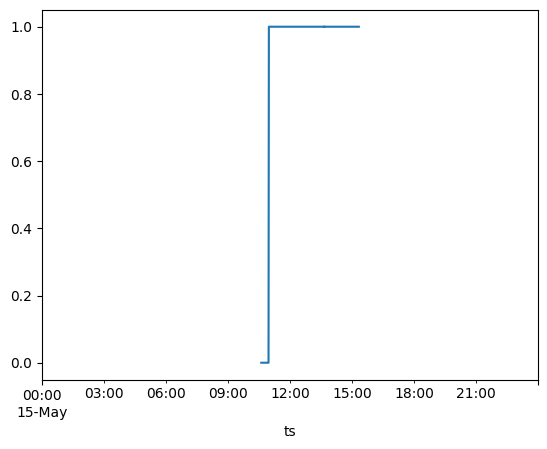

In [12]:
df['LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load'].plot()

In [21]:
project_id = data_holder.project_id
project_id

'c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc'

In [33]:
from ai.utils.holiday_workday_utils import get_week_holiday, load_project_holidays, get_weekday

holidays = load_project_holidays(project_id)


def get_week_holiday_for_df(val):
    return get_week_holiday(project_id, val, holidays=holidays)


apply_func = get_week_holiday_for_df if holidays is not None else get_weekday

df['weekday'] = df['ts'].apply(apply_func)
df

ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')


,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday
ts,,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None,wednesday
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None,wednesday
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None,wednesday
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None,wednesday
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None,wednesday
...,...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None,wednesday
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None,wednesday
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None,wednesday


In [38]:
df['start_operating_hours'] = df['weekday'].apply(
    lambda x: operating_hours[x]['start'])
df['end_operating_hours'] = df['weekday'].apply(
    lambda x: operating_hours[x]['end'])
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours
ts,,,,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
...,...,...,...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"


In [46]:
buffer = 1  # 1 hour buffer

# Convert JSON time to datetime.time object
import datetime

df['start_time'] = df['start_operating_hours'].apply(lambda x: datetime.time(
    min(x['hours'] - buffer, 0), x['minutes'], x['seconds']))
df['end_time'] = df['end_operating_hours'].apply(
    lambda x: datetime.time(max(x['hours'] + buffer, 23), x['minutes'], x['seconds']))
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_time,end_time
ts,,,,,,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
...,...,...,...,...,...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00


In [49]:
# Lambda function to check if timestamp is between start and end times
check_time = lambda row: row['start_time'] <= row['ts'].time() <= row['end_time']

# Apply the lambda function
df['is_within_time'] = df.apply(check_time, axis=1)
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_time,end_time,is_within_time
ts,,,,,,,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
...,...,...,...,...,...,...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False


In [54]:
df['load_in_window'] = df['is_within_time'] & df["load"]
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_time,end_time,is_within_time,load_in_window
ts,,,,,,,,,,
2024-05-15 00:00:00+02:00,4.16,2024-05-15 00:00:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 00:01:00+02:00,4.16,2024-05-15 00:01:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 00:02:00+02:00,4.16,2024-05-15 00:02:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 00:03:00+02:00,4.16,2024-05-15 00:03:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 00:04:00+02:00,4.16,2024-05-15 00:04:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
...,...,...,...,...,...,...,...,...,...,...
2024-05-15 23:55:00+02:00,None,2024-05-15 23:55:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 23:56:00+02:00,None,2024-05-15 23:56:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False
2024-05-15 23:57:00+02:00,None,2024-05-15 23:57:00+02:00,None,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",00:28:00,23:28:00,False,False


In [55]:
df['load_in_window'].sum() / df["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"].sum()

1.0

In [68]:
from ai.interface.data_holder import DataHolder
from ai.utils.holiday_workday_utils import load_project_operating_hours
from ai.utils.holiday_workday_utils import get_week_holiday, load_project_holidays, get_weekday


def get_score(_dh: DataHolder, _start: int, _end: int, _buffer: int = 1):
    try:
        df = _dh.get_data(start=_start, end=_end)
        df.columns = ['variable']
        v = data_holder.get_prediction_variable()
        data = fetch_data_from_http(
            v, data_holder.project_id, start, end, "1m")
        df = append_data_to_dataframe_http(df, data, v)
        df.rename(columns={v: 'load'}, inplace=True)

        operating_hours = load_project_operating_hours(data_holder.project_id)

        holidays = load_project_holidays(_dh.project_id)

        def get_week_holiday_for_df(val):
            return get_week_holiday(_dh.project_id, val, holidays=holidays)

        # apply week day for timestamp
        apply_func = get_week_holiday_for_df if holidays is not None else get_weekday

        df['weekday'] = df['ts'].apply(apply_func)
        df['start_operating_hours'] = df['weekday'].apply(
            lambda x: operating_hours[x]['start'])

        df['end_operating_hours'] = df['weekday'].apply(
            lambda x: operating_hours[x]['end'])

        # Convert JSON time to datetime.time object
        df['start_time'] = df['start_operating_hours'].apply(lambda x: datetime.time(
            min(x['hours'] - buffer, 0), x['minutes'], x['seconds']))
        df['end_time'] = df['end_operating_hours'].apply(
            lambda x: datetime.time(max(x['hours'] + buffer, 23), x['minutes'], x['seconds']))

        # Lambda function to check if timestamp is between start and end times
        def check_time(
            row): return row['start_time'] <= row['ts'].time() <= row['end_time']

        # Apply the lambda function
        df['is_within_time'] = df.apply(check_time, axis=1)

        # is load in window
        df['load_in_window'] = df['is_within_time'] & df["load"]

        return df['load_in_window'].sum() / df["load"].sum()
    except:
        return 0.0

In [71]:
get_score(data_holder, start, end)

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]
ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')


1.0